In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm, trange
from matplotlib import pyplot as plt 
import networkx as nx
import numpy as np

%matplotlib inline

In [155]:
import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url


class MyOwnDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return ["CR_graph_rel.csv"]

    @property
    def processed_file_names(self):
        return ['data_0.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass
        
    
    def process(self):
        d = {
            'мордвины': torch.tensor(0, dtype=torch.long),
            'белорусы': torch.tensor(1, dtype=torch.long),
            'украинцы': torch.tensor(2, dtype=torch.long),
            'южные-русские': torch.tensor(3, dtype=torch.long),
            'северные-русские': torch.tensor(4, dtype=torch.long)
        }
        oho = {
            'мордвины': torch.tensor([1, 0, 0, 0, 0], dtype=torch.float),
            'белорусы': torch.tensor([0, 1, 0, 0, 0], dtype=torch.float),
            'украинцы': torch.tensor([0, 0, 1, 0, 0], dtype=torch.float),
            'южные-русские': torch.tensor([0, 0, 0, 1, 0], dtype=torch.float),
            'северные-русские': torch.tensor([0, 0, 0, 0, 1], dtype=torch.float)
        }
        
        idx = 0
        for raw_path in self.raw_paths:
            edge_index = []
            edge_attr = []
            
            y_labels = {}
            oho_labels = {}
            
            dataset_csv = pd.read_csv(raw_path)
            
            for index, row in tqdm(dataset_csv.iterrows()):
                node1 = row["node_id1"]
                node2 = row["node_id2"]
                label1 = row["label_id1"]
                label2 = row["label_id2"]
                ibd_sum = row["ibd_sum"]

                id1 = int(node1[5:])
                id2 = int(node2[5:])

                edge_index.append(torch.tensor([id1, id2], dtype=torch.long))
                edge_index.append(torch.tensor([id2, id1], dtype=torch.long))
                edge_attr.append(torch.tensor([ibd_sum], dtype=torch.float))
                edge_attr.append(torch.tensor([ibd_sum], dtype=torch.float))

                if id1 not in oho_labels:
                    y_labels[id1] = d[label1]
                    oho_labels[id1] = oho[label1]
                if id2 not in oho_labels:
                    y_labels[id2] = d[label2]
                    oho_labels[id2] = oho[label2]
            
            y_labels = dict(sorted(y_labels.items()))
            y = torch.stack(list(y_labels.values()))
            
            oho_labels = dict(sorted(oho_labels.items()))
            x = torch.stack(list(oho_labels.values()))
            edge_attr = torch.stack(edge_attr).contiguous()
            edge_index = torch.stack(edge_index).t().contiguous()

            data = Data(x=x ,edge_index=edge_index, edge_attr=edge_attr, y=y)
            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [156]:
dataset = MyOwnDataset(root="train_data/")

Processing...
32799it [00:02, 11705.96it/s]
Done!


In [157]:
data = dataset.get(0)

In [158]:
data

Data(x=[2625, 5], edge_index=[2, 65598], edge_attr=[65598, 1], y=[2625])

In [6]:
data.x

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [7]:
def visualize_graph(G, color):
    plt.figure(figsize=(16, 12))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2", node_size=50)
    plt.show()

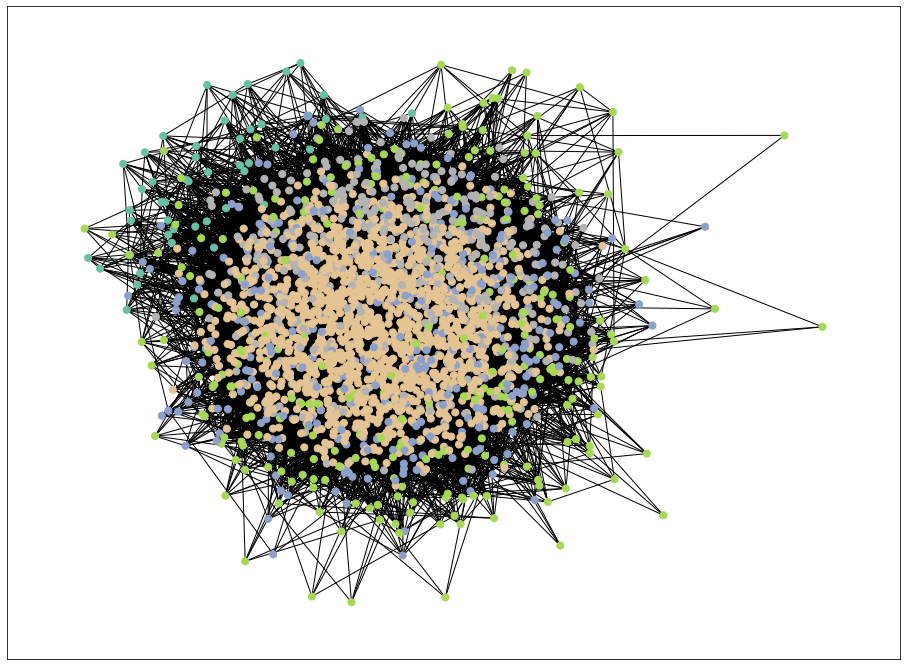

CPU times: user 45.1 s, sys: 270 ms, total: 45.4 s
Wall time: 46.2 s


In [8]:
%%time 

from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=torch.argmax(data.x, axis=1))

In [9]:
from torch_geometric.transforms import RandomNodeSplit

In [10]:
transform = RandomNodeSplit(split='train_rest', num_splits=1,
                                num_val=0.0, num_test=0.3)

In [11]:
data = transform(data)

In [12]:
len(data)

7

In [11]:
class FocalLoss(torch.nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight # weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [12]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GATConv


class AttnGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GATConv(in_channels=5,
                             out_channels=5,
                             heads=2, 
                             add_self_loops=False,
                             edge_dim=1)
        self.fc1 = Linear(10, 10)
        self.fc2 = Linear(10, 5)

    def forward(self, x, edge_index, edge_weight):
        h = self.conv1(x, edge_index, edge_weight)
        h = h.relu()
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        return h

In [184]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(5, 10, 
                             add_self_loops=False,
                             normalize=False)
#         self.conv2 = GCNConv(10, 10, 
#                              add_self_loops=False,
#                              normalize=True)
        self.fc1 = Linear(10, 10)
        self.fc2 = Linear(10, 5)

    def forward(self, x, edge_index, edge_weight):
        h = self.conv1(x, edge_index, edge_weight)
        h = h.relu()
        # h = self.conv2(h, edge_index, edge_weight)
        # h = h.relu()
        h = self.fc1(h)
        h = h.relu()
        h = self.fc2(h)
        return h

In [185]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
# criterion = FocalLoss(weight= 1. / torch.tensor([70, 463, 426, 2177, 631], dtype=torch.float))

In [186]:
model

GCN(
  (conv1): GCNConv(5, 10)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=5, bias=True)
)

In [187]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

def train(epoch):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index, data.edge_attr)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

In [188]:
t = trange(5000, leave=True)

for epoch in t:
    loss = train(epoch)
    t.set_description(str(round(loss.item(), 6)))

0.21114: 100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:27<00:00, 57.04it/s]


In [183]:
torch.save(model, "model.pt")

In [132]:
full_data

Data(x=[3767, 5], edge_index=[2, 135006], edge_attr=[135006, 1], y=[3767])

In [135]:
full_dataset = MyOwnDataset(root="data/")
full_data = full_dataset.get(0)

In [136]:
import random
random.seed(42)

test_mask = []

for i in range(3767):
    if random.random() < 0.7:
        test_mask.append(False)
    else:
        test_mask.append(True)

test_mask = torch.tensor(test_mask)

In [137]:
test_mask[:100]

tensor([False, False, False, False,  True, False,  True, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
         True, False, False, False,  True, False, False, False,  True, False,
         True,  True, False,  True, False, False,  True, False,  True, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False,  True, False, False,
         True, False, False, False,  True,  True, False, False, False, False,
        False,  True,  True, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False,  True, False, False, False,
        False, False,  True, False, False, False,  True, False,  True,  True])

In [138]:
def test(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_attr)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [139]:
test(model, full_data, test_mask)

0.9387040280210157

In [140]:
out = model(full_data.x, full_data.edge_index, full_data.edge_attr)

In [141]:
pred = out.argmax(dim=1)


In [143]:
test_correct = pred == full_data.y



In [125]:
test_correct

tensor([True, True, True,  ..., True, True, True])

In [121]:
test_correct == test_mask

RuntimeError: The size of tensor a (1142) must match the size of tensor b (3767) at non-singleton dimension 0

In [73]:
test_correct

tensor([False, False,  True,  ...,  True,  True,  True])

In [74]:
test_mask

tensor([0, 0, 0,  ..., 0, 0, 0])

In [75]:
full_data.y[test_mask]

tensor([0, 0, 0,  ..., 0, 0, 0])

In [76]:
test_mask[100] = 100

In [62]:
test_mask.sum()

tensor(1142)

In [63]:
test_correct.sum()

tensor(0)

In [48]:
test_correct.shape

torch.Size([3767])

In [50]:
test_correct.sum() / len(test_correct)

tensor(0.9493)

In [51]:
2456 / 2625

0.9356190476190476

In [52]:
full_data.y

tensor([0, 0, 0,  ..., 1, 1, 1])

In [50]:
pred

tensor([3, 3, 0,  ..., 1, 1, 1])

In [48]:
test_correct[:100]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

0.9451327433628318

In [40]:
out = model(data.x, data.edge_index, data.edge_attr)
pred = out.argmax(dim=1)
test_correct = pred[data.test_mask] == data.y[data.test_mask]

In [41]:
d = {
            'мордвины': 0,
            'белорусы': 1,
            'украинцы': 2,
            'южные-русские': 3,
            'северные-русские': 4,
        }
counts = {0: 70, 1: 463, 2: 426, 3: 2177, 4: 631}

In [44]:
import sklearn.metrics
sklearn.metrics.confusion_matrix(data.y[data.test_mask], pred[data.test_mask], labels=None, normalize=None)

array([[ 20,   0,   0,   4,   0],
       [  0, 122,   6,  10,   2],
       [  0,   2, 116,  20,   0],
       [  1,   2,   0, 630,   2],
       [  0,   2,   0,  11, 180]])

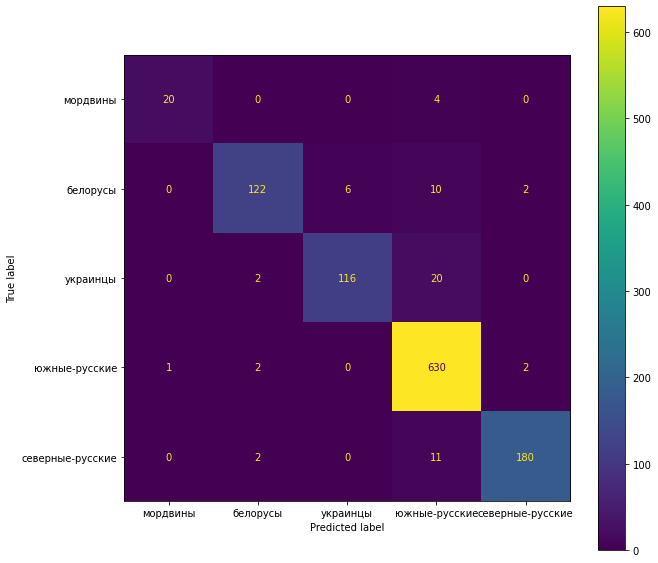

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sub_etnos = ['мордвины', 'белорусы', 'украинцы', 'южные-русские', 'северные-русские']

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(data.y[data.test_mask], pred[data.test_mask], display_labels=sub_etnos, ax=ax)

## Attn model

Focal loss
```
array([[ 18,   1,   0,   0,   0],
       [  9, 124,   3,   5,   5],
       [ 13,   2,  94,   4,   0],
       [ 18,   3,   7, 618,   1],
       [  7,   1,   1,   3, 193]])
```


CE
```
array([[ 16,   2,   0,   1,   0],
       [  1, 125,   3,  13,   4],
       [  0,   2,  95,  16,   0],
       [  4,   1,   6, 635,   1],
       [  1,   2,   1,   7, 194]])
```




## Simple model

Focal loss

```
array([[ 23,   0,   0,   0,   2],
       [  9,  87,  14,  18,   9],
       [ 22,   9,  89,   2,   8],
       [ 23,  59,  54, 479,  48],
       [ 12,  12,   8,  17, 126]])
 ```
 
 CE loss
 
 ```
 array([[ 18,   0,   0,   5,   2],
       [  0,  67,  10,  56,   4],
       [  0,   4,  69,  50,   7],
       [  1,  17,  16, 601,  28],
       [  1,   7,   4,  46, 117]])
```

In [266]:
import numpy as np

In [269]:
W1 = np.array([[0, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1]])

X = np.array([[1, 2, 3, 4],
              [1, 2, 3, 4],
              [1, 2, 3, 4],
              [1, 2, 3, 4],
              [1, 2, 3, 4]])

In [272]:
np.dot(W1, X)

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 5, 10, 15, 20]])

In [ ]:
W1 = np.array([[1, 0, 0, 0, 0], 
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1]])

X = np.array([[1, 2, 3, 4],
              [1, 2, 3, 4],
              [1, 2, 3, 4],
              [1, 2, 3, 4],
              [1, 2, 3, 4]])

In [274]:

m = GCN()
print(m)

out, h = m(data.x, data.edge_index, data.edge_attr)

GCN(
  (conv1): GCNConv(5, 16)
  (conv2): GCNConv(16, 5)
)


ValueError: too many values to unpack (expected 2)

In [306]:
inp = torch.tensor([[0.1, 0.8, 0.1]], dtype=torch.float)

In [305]:
inp.shape

torch.Size([1, 3])

In [300]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

NameError: name 'nn' is not defined

In [316]:
criterion = torch.nn.CrossEntropyLoss()
input = torch.tensor([[3.2, 1.3,0.2, 0.8], 
                     [3.2, 1.3,0.2, 0.8],
                     [3.2, 1.3,0.2, 0.8]],dtype=torch.float)
target = torch.tensor([0, 0, 0], dtype=torch.long)
criterion(input, target)

tensor(0.2547)

In [313]:
input.softmax(dim=1)

tensor([[0.7751, 0.1159, 0.0386, 0.0703],
        [0.7751, 0.1159, 0.0386, 0.0703]])

In [78]:
data_csv = pd.read_csv("data/raw/CR_graph_rel.csv")

In [79]:
data_csv

,node_id1,node_id2,label_id1,label_id2,ibd_sum,ibd_n
0,node_0,node_5,мордвины,мордвины,29.81720,4
1,node_0,node_10,мордвины,мордвины,11.63220,1
2,node_0,node_11,мордвины,мордвины,23.90440,2
3,node_0,node_18,мордвины,мордвины,11.25290,1
4,node_0,node_20,мордвины,мордвины,8.88252,1
...,...,...,...,...,...,...
67498,node_3741,node_3752,белорусы,белорусы,9.51327,1
67499,node_3745,node_3755,белорусы,белорусы,9.23221,1
67500,node_3749,node_3764,белорусы,белорусы,10.63310,1
67501,node_3754,node_3755,украинцы,белорусы,8.04722,1


In [184]:
edge_index

tensor([[0],
        [5]])

In [187]:
d = {
            'мордвины': torch.tensor(0, dtype=torch.long),
            'белорусы': torch.tensor(1, dtype=torch.long),
            'украинцы': torch.tensor(2, dtype=torch.long),
            'южные-русские': torch.tensor(3, dtype=torch.long),
            'северные-русские': torch.tensor(4, dtype=torch.long)
        }



edge_index = []
edge_attr = []

y_labels = {}
oho_labels = {}

for index, row in tqdm(data_csv.iterrows()):
    node1 = row["node_id1"]
    node2 = row["node_id2"]
    label1 = row["label_id1"]
    label2 = row["label_id2"]
    ibd_sum = row["ibd_sum"]

    id1 = int(node1[5:])
    id2 = int(node2[5:])

    edge_index.append(torch.tensor([id1, id2], dtype=torch.long))
    edge_attr.append(torch.tensor([ibd_sum], dtype=torch.float))

    if id1 not in oho_labels:
        y_labels[id1] = d[label1]
    if id2 not in oho_labels:
        y_labels[id2] = d[label2]

y_labels = dict(sorted(y_labels.items()))
y = torch.stack(list(y_labels.values()))

edge_attr = torch.stack(edge_attr).contiguous()
edge_index = torch.stack(edge_index).t().contiguous()

67503it [00:13, 5057.07it/s]


In [192]:
from collections import defaultdict
counts = defaultdict(int)

for l in y_labels:
    counts[y_labels[l].item()] += 1 

In [193]:
counts

defaultdict(int, {0: 70, 1: 463, 2: 426, 3: 2177, 4: 631})

In [176]:
ibd_sum = row["ibd_sum"]

KeyError: 'ibd_sum'

In [79]:
from collections import defaultdict

d = defaultdict(int)
ibd_s = defaultdict(list)
connections = np.zeros([3767, 6], dtype=int)

data_csv = pd.read_csv("data/raw/CR_graph_rel.csv")

nations = {
            'мордвины': 0,
            'белорусы': 1,
            'украинцы': 2,
            'южные-русские': 3,
            'северные-русские': 4,
        }

for index, row in tqdm(data_csv.iterrows()):
    node1 = row["node_id1"]
    node2 = row["node_id2"]
    label1 = row["label_id1"]
    label2 = row["label_id2"]
    ibd_sum = row["ibd_sum"]    
    
    ibd_ = []
    
    key = label1 + "___" + label2
    reverse_key = label2 + "___" + label1
    
    if reverse_key in d:
        d[reverse_key] += 1
        ibd_s[reverse_key].append(ibd_sum)
    else:
        d[key] += 1
        ibd_s[key].append(ibd_sum)
    
    id1 = int(node1[5:])
    id2 = int(node2[5:])
    
    connections[id1][nations[label2]+1] += ibd_sum
    connections[id2][nations[label1]+1] += ibd_sum
    connections[id1][0] = nations[label1]
    connections[id2][0] = nations[label2]

67503it [00:04, 14366.21it/s]


In [80]:
for key in ibd_s:
    print(key, round(np.mean(ibd_s[key]), 2), round(np.std(ibd_s[key]), 2))

мордвины___мордвины 20.73 20.28
мордвины___южные-русские 9.88 2.59
мордвины___северные-русские 10.91 4.22
мордвины___белорусы 9.56 1.95
мордвины___украинцы 9.54 1.63
белорусы___северные-русские 9.91 2.47
белорусы___южные-русские 9.99 2.57
белорусы___белорусы 27.42 235.24
белорусы___украинцы 10.1 8.05
украинцы___южные-русские 9.93 2.62
украинцы___северные-русские 9.89 2.28
украинцы___украинцы 36.6 274.93
южные-русские___южные-русские 14.5 104.91
южные-русские___северные-русские 9.96 2.54
северные-русские___северные-русские 12.52 72.48


In [81]:
d

defaultdict(int,
            {'мордвины___мордвины': 268,
             'мордвины___южные-русские': 394,
             'мордвины___северные-русские': 256,
             'мордвины___белорусы': 42,
             'мордвины___украинцы': 38,
             'белорусы___северные-русские': 1851,
             'белорусы___южные-русские': 7144,
             'белорусы___белорусы': 1759,
             'белорусы___украинцы': 1085,
             'украинцы___южные-русские': 4902,
             'украинцы___северные-русские': 1137,
             'украинцы___украинцы': 1231,
             'южные-русские___южные-русские': 33241,
             'южные-русские___северные-русские': 10225,
             'северные-русские___северные-русские': 3930})

In [82]:
person_nation_connections = defaultdict(list)
for i in range(len(connections)):
    person_nation_connections[connections[i][0]].append(connections[i][1:])

person_nation_connections_mean = {}
for key in person_nation_connections: 
    mean = np.mean(np.array(person_nation_connections[key]), axis=0)
    person_nation_connections_mean[key] = np.around(mean, 2)

In [83]:
person_nation_connections_mean

{0: array([154.97,   5.47,   4.97,  53.1 ,  38.24]),
 1: array([  0.83, 204.83,  22.64, 147.31,  37.82]),
 2: array([  0.82,  24.61, 208.88, 109.12,  25.22]),
 3: array([  1.71,  31.33,  21.35, 429.  ,  44.7 ]),
 4: array([  4.24,  27.75,  17.02, 154.21, 150.19])}

In [171]:
person_nation_connections_mean

{0: array([154.97142857,   5.47142857,   4.97142857,  53.1       ,
         38.24285714]),
 1: array([  0.82721382, 204.825054  ,  22.64146868, 147.30669546,
         37.81857451]),
 2: array([  0.81690141,  24.60798122, 208.88262911, 109.11502347,
         25.21596244]),
 3: array([  1.7073955 ,  31.32889297,  21.35186036, 428.99954065,
         44.69637115]),
 4: array([  4.24247227,  27.7496038 ,  17.02377179, 154.20602219,
        150.18700475])}

In [129]:
x[0][0] += 1

In [133]:
l = [1, 2, 3]

In [134]:
l[0] = 10

In [135]:
l

[10, 2, 3]

In [156]:
np.zeros([3767, 5])

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])